## Assignment 9

# Tracking and forecasting in conditions of measurement gaps

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of this laboratory work is to develop the estimation and tracking algorithm in conditions of measurement gaps, that is of prime importance for many practical control and forecasting problems. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output.**

In [14]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import copy
np.random.seed(7)

**Firstly, we generate a true trajectory $x_i$ of an object motion disturbed by normally distributed random acceleration:**

In [15]:
def motion(initialX,initialV,initialT,noiseSigma,size):
    x = [initialX]
    v  = [initialV]
    acceleration = 0
    for i in range(1,size):
        x.append(x[i - 1] + v[i - 1]*initialT + acceleration*initialT**2/2)
        v.append(v[i - 1] + acceleration * initialT)
        acceleration = np.random.normal(0, noiseSigma)
    return x,v

In [16]:
# Initial conditions, variance of noise, size of trajectory

initialX = 5
initialV = 1
initialT = 1
internalNoiseSigma = 0.2
size = 200
measSigma = 20

**Secondly, we generate measurements $z_i$ of the coordinate $x_i$, but this time we don't have measurements for every time step - there are some gaps which appear with specified probability ξ:**

In [17]:
def measurements(process,mean,sigma,P=0.2):
    arr = process.copy()
    ξ = np.random.uniform(low=0.0, high=1.0, size=200)
    for i in range(0,len(arr)):
        if ξ[i] > P:
            arr[i] = arr[i] + np.random.normal(mean,sigma)
        else:
            arr[i] = None
    return arr

**Some helpful functions which help us develop Kalman filter algorithm and visualize data:**

In [18]:
# Function which takes two processes as input and returns their combination as a vector

def giveVectors(processX,processV):
    X = []
    lastIndexX = len(processX) - 1
    lastIndexV = len(processV) - 1
    for i in range(0,max(lastIndexX + 1,lastIndexV + 1)):
        x = [[],[]]
        if(lastIndexX < i):
            x[0].append(0)
        else:
            x[0].append(processX[i])
        if(lastIndexV < i):
            x[1].append(0)
        else:
            x[1].append(processV[i])
        X.append(np.matrix((x)))
    return X

In [19]:
# Function which takes a vector as input and returns dafa from a specified axis

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

In [20]:
# Plotting function

def showPlease(arr,legend,xlabel,ylabel,title):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In order to present the system at state space, we define a period T and introduce F - transition matrix that relates $X_i$ and $X_{i-1}$, G - input matrix that determines how random acceleration $a_i$ affects state vector, H - observation matrix:**

In [21]:
T = 1
F = np.matrix([[1,T],
              [0,1]])
G = np.matrix([[T**2/2],
               [T]])
H = np.matrix([[1,0]])

**Now, we develop Kalman filter algorithm to estimate state vector $X_i$ with given initial filtered estimate and initial filtration error covariance matrix:**

In [22]:
# Initial filtred estimate and initial filtration error covariance matrix

initialKalmanX_3 = np.matrix([[2],
                              [0]])
initialP_3 = np.matrix([[10000,0],
                        [0,10000]])

**The algorithm is optimized to operate with measurement gaps: if there is a gap in measurements, the algorithm indicates that the filtered estimate is equal to extrapolated estimate and filtration error covariance matrix is equal to extrapolation error covariance matrix during the filtration:**

In [68]:
# The algorithm itself

class KalmanFilter:
    
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G,v):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        self.trueV= v.copy()
        
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        self.measStates = measStates.copy()
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errorsSq(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((self.trueTrajectory[i] - listValues[i - start ])**2)
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)
        
    def errorsVSq(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((self.trueV[i] - listValues[i - start ])**2)
        return errors
        
    def giveK(self,predictedP,H,R):
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):
        return self.measSigma**2
    
    def giveH(self,index):
        return self.H
    
    def giveF(self,firstIndex,secondIndex):
        return self.F
    
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        if meas[0] != None:
            x = predictedX + K*(meas - H*predictedX)
            KH = K*H
            P = (np.identity(KH.shape[0]) - KH) * predictedP
        else:
            x = predictedX
            P = predictedP
        return x,P
    
    def givePError(self):
        p = []
        for i in self.listP:
            p.append((i.item(0,0))**0.5)
        return p
    
    def givePErrorV(self):
        p = []
        for i in self.listP:
            p.append((i.item(1,1))**0.5)
        return p

In [24]:
# Function which runs the algorithm

def createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,P):
    processX,v = motion(initialX,initialV,initialT,noiseSigma,size)
    meas = measurements(processX,0,measSigma,P)
    states = giveVectors(meas,[])
    return KalmanFilter(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G,v)

In [25]:
# Run the algorithm
kalman = createProcessGiveKalman(size,initialX,initialV,T,internalNoiseSigma,measSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,0.2)

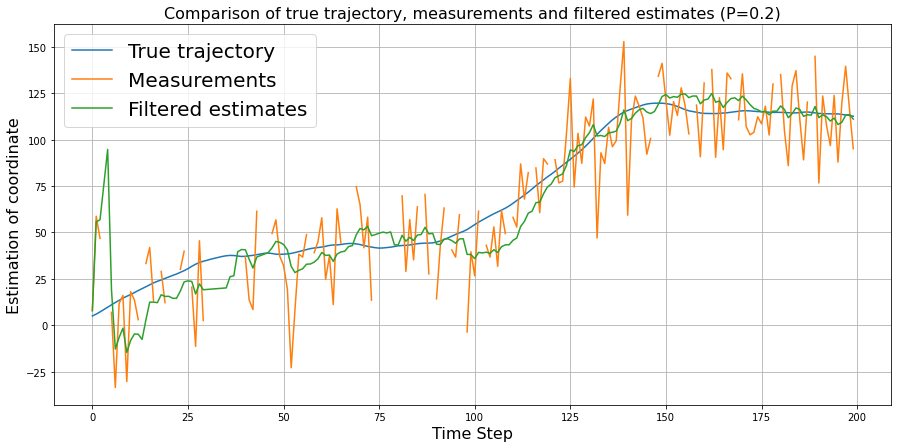

In [26]:
# Plot true trajectory, measurements, filtered estimates

showPlease([kalman.trueTrajectory,kalman.measTrajectory,kalman.kalmanTrajectory],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Estimation of coordinate',
            'Comparison of true trajectory, measurements and filtered estimates (P=0.2)')

**Despite  the gaps in measurements, Kalman filter correctly describes true trajectory trend making it possible to track moving object. In order to estimate dynamics of mean-squared error of estimation over observation interval, we determine filtered and extrapolated on  1 and 7 steps ahead errors of estimation by running Kalman filter M = 500 times:**

In [27]:
def manyKalman(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G,P):
    filteredErrorsTotal = [0 for x in range(2,size)]
    filteredErrorsTotalV = [0 for x in range(0,size)]
    predictedErrorsTotal = [0 for x in range(0,size - predictStep + 1)]
    predictedErrorsTotal1 = [0 for x in range(0,size -1)]
    for i in range(0,amount):
        kalman = createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,P)
        filteredErrors = kalman.errorsSq(kalman.kalmanTrajectory)
        predictedErrors = kalman.errorsSq(giveElements(kalman.extrapolate(predictStep),0))
        predictedErrors1 = kalman.errorsSq(giveElements(kalman.extrapolate(2),0))
        filteredErrorsV = kalman.errorsVSq(giveElements(kalman.kalmanStates,1))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]
        for j in range(0,size - predictStep + 1):
            predictedErrorsTotal[j] = predictedErrorsTotal[j] + predictedErrors[j]
        for j in range(0,size - 1):
            predictedErrorsTotal1[j] = predictedErrorsTotal1[j] + predictedErrors1[j]
        for j in range(0,size):
            filteredErrorsTotalV[j] = filteredErrorsTotalV[j] + filteredErrorsV[j]
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
        filteredErrorsTotalV[i] = (filteredErrorsTotalV[i]/(amount - 1))**0.5
    for i in range(0,size - predictStep + 1):
        predictedErrorsTotal[i] = (predictedErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size - 1):
        predictedErrorsTotal1[i] = (predictedErrorsTotal1[i]/(amount - 1))**0.5
    return filteredErrorsTotal,filteredErrorsTotalV,predictedErrorsTotal1, predictedErrorsTotal

In [32]:
true_err,true_errV,pred1,pred7 = manyKalman(size,500,initialX,initialV,T,internalNoiseSigma,measSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,0.2)

**Now we compare true estimation errors with standard deviation provided by Kalman filter to estimate the accuracy of the optimised algorithm:**

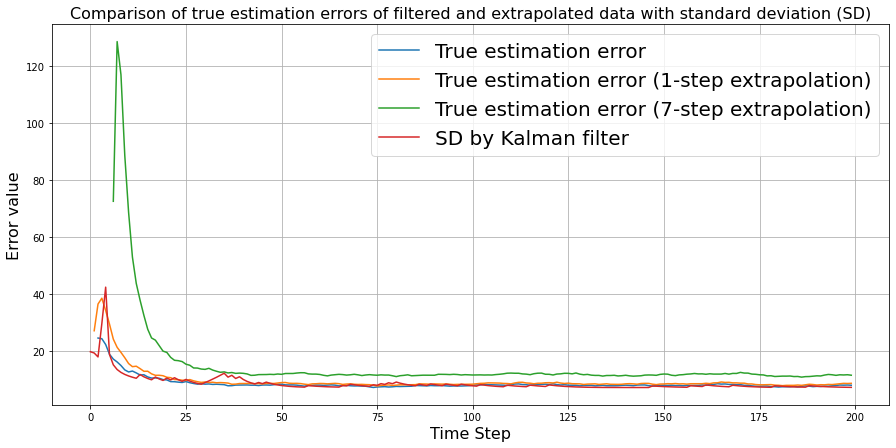

In [88]:
showPlease([true_err,pred1,pred7,kalman.givePError()],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-step extrapolation)', 
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (SD)');

**Let us have a closer look on errors: we will exclude first several points causing high peaks of SD and true estimation error (case of extrapolation on 7 steps ahead) values to be able to estimate visually the errors:**

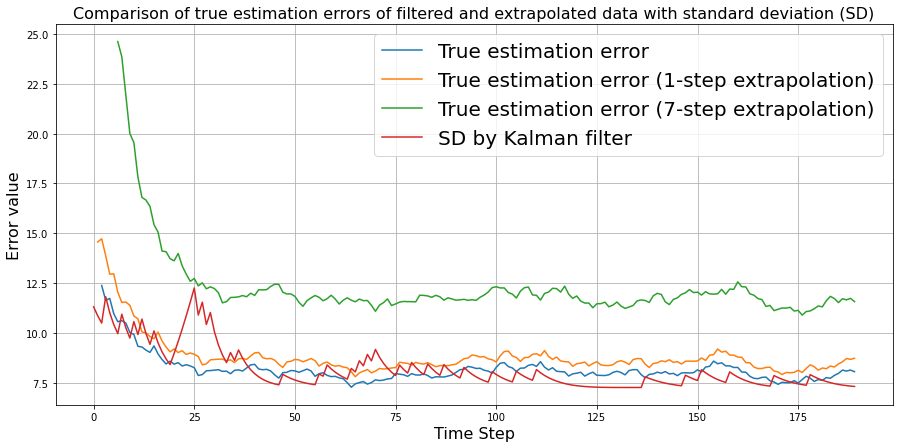

In [90]:
showPlease([true_err[10:200], pred1[10:200], pred7[10:200], kalman.givePError()[10:200]],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-step extrapolation)',
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (SD)');

**It is clearly seen from the graph that true estimation errors correspond to standard deviation values as it should be - it means that optimised Kalman filter shows its best accuracy despite the fact there are some gaps in measurements. As for extrapolated on 1 and 7 steps ahead estimations, the error values are increasing with the growth of extrapolation steps number,  but still the capability of filter to forecast remains quite good. It was also noted that the crests of SD correspond to the gaps of measurements.**

**Now let us analyze the decrease of estimation accuracy in conditions of measurement gaps with higher probabilities:**

In [70]:
# (a) P = 0.3
kalman_a = createProcessGiveKalman(size,initialX,initialV,T,internalNoiseSigma,measSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,0.3)

true_err_a,true_errV_a,pred1_a,pred7_a = manyKalman(size,500,initialX,initialV,T,internalNoiseSigma,measSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,0.3)

In [71]:
# (b) P = 0.5
kalman_b = createProcessGiveKalman(size,initialX,initialV,T,internalNoiseSigma,measSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,0.5)

true_err_b,true_errV_b,pred1_b,pred7_b = manyKalman(size,500,initialX,initialV,T,internalNoiseSigma,measSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,0.5)

In [72]:
# (c) P = 0.7
kalman_c = createProcessGiveKalman(size,initialX,initialV,T,internalNoiseSigma,measSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,0.7)

true_err_c,true_errV_c,pred1_c,pred7_c = manyKalman(size,500,initialX,initialV,T,internalNoiseSigma,measSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,0.7)

In [73]:
# (d) P = 0.9
kalman_d = createProcessGiveKalman(size,initialX,initialV,T,internalNoiseSigma,measSigma,
                                   initialKalmanX_3,initialP_3,"usual",[],H,F,G,0.9)

true_err_d,true_errV_d,pred1_d,pred7_d = manyKalman(size,500,initialX,initialV,T,internalNoiseSigma,measSigma,
               initialKalmanX_3,initialP_3,7,"usual",[],H,F,G,0.9)

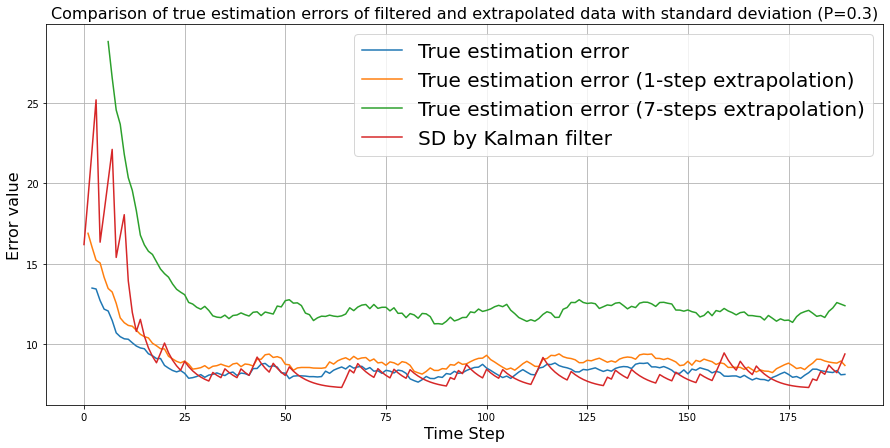

In [74]:
showPlease([true_err_a[10:200], pred1_a[10:200], pred7_a[10:200], kalman_a.givePError()[10:200]],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-steps extrapolation)',
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (P=0.3)');

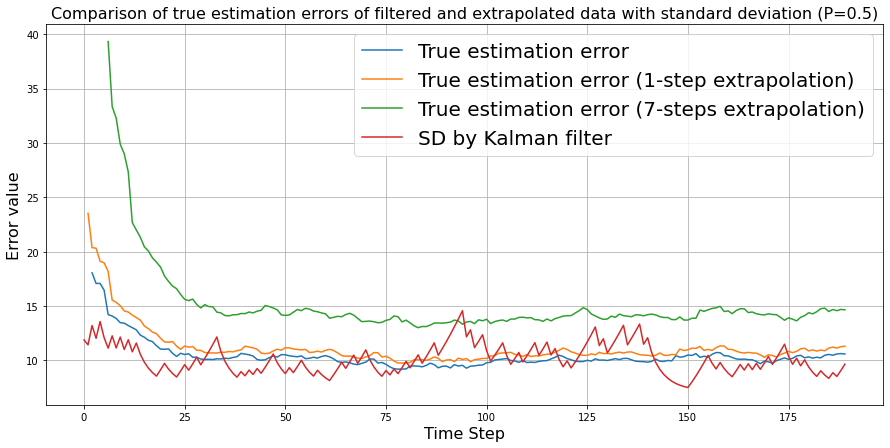

In [75]:
showPlease([true_err_b[10:200], pred1_b[10:200], pred7_b[10:200], kalman_b.givePError()[10:200]],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-steps extrapolation)',
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (P=0.5)');

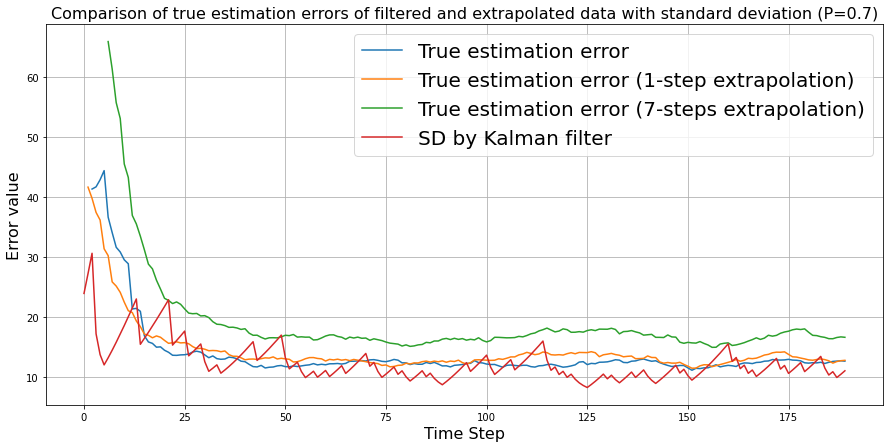

In [76]:
showPlease([true_err_c[10:200], pred1_с[10:200], pred7_с[10:200], kalman_c.givePError()[10:200]],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-steps extrapolation)', 
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (P=0.7)');

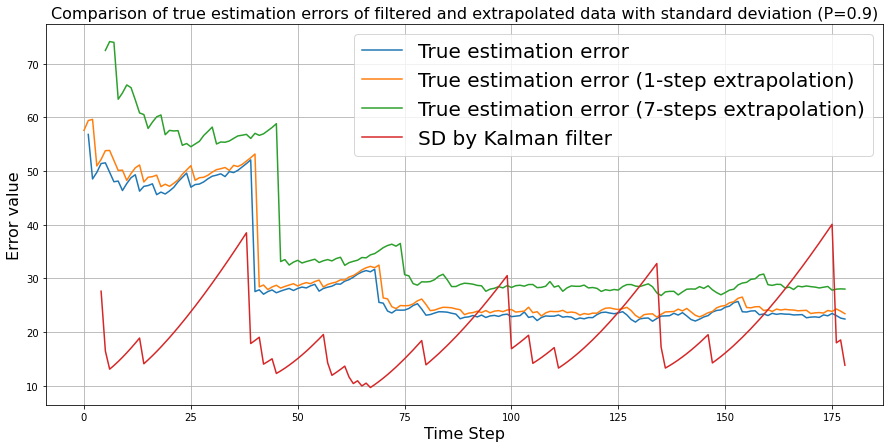

In [77]:
showPlease([true_err_d[20:200], pred1_d[20:200], pred7_d[20:200], kalman_d.givePError()[25:200]],['True estimation error', 
           'True estimation error (1-step extrapolation)', 'True estimation error (7-steps extrapolation)',  
           'SD by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and extrapolated data with standard deviation (P=0.9)');

**Obvious outcome of the increase of gap probability is that the error values dramatically rise as well. Approximately, 20% increase in the gap probability leads to a ~10% increase in error values. However, the last case shows huge fluctuations of calculation errors provided by Kalman filter, and the increase of error values is more significant compared to previous cases, so 90% measurement loss results in high inaccuracy. All results regarding extrapolation show an increase of true errors with the growth of number of steps as well as the gap probability.**

**Let us compare true errors of velocity obtained for each gap probability value with standard deviation values:**

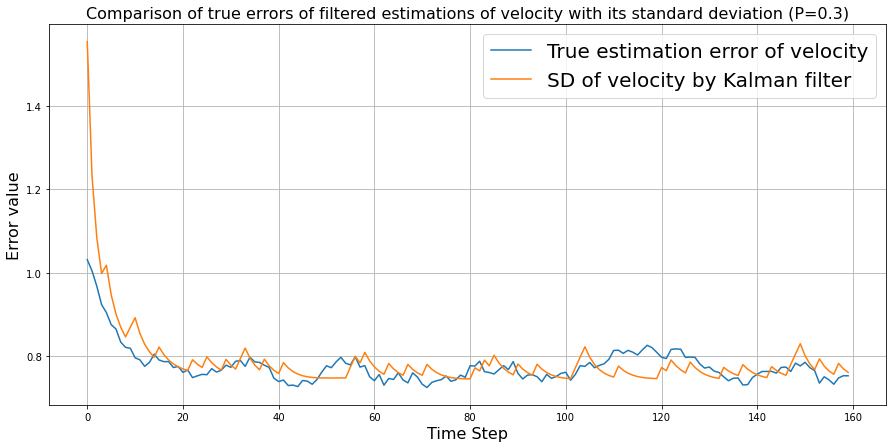

In [82]:
showPlease([true_errV_a[20:180], kalman_a.givePErrorV()[20:180]], 
           ['True estimation error of velocity',  
           'SD of velocity by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true errors of filtered estimations of velocity with its standard deviation (P=0.3)');

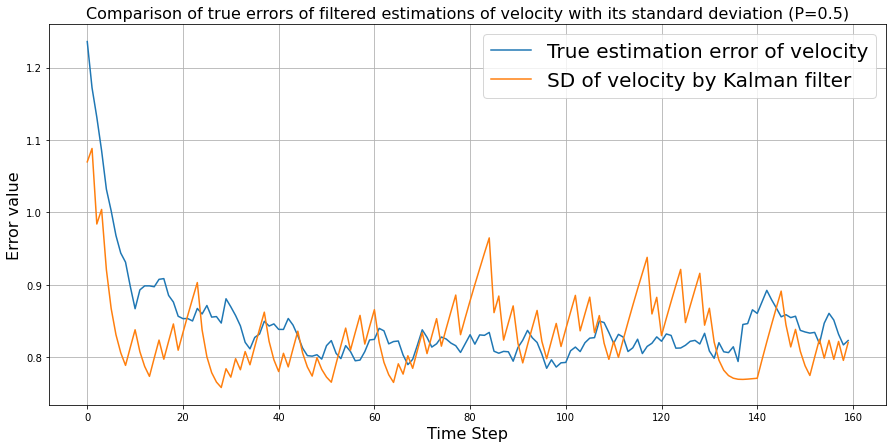

In [85]:
showPlease([true_errV_b[20:180], kalman_b.givePErrorV()[20:180]], 
           ['True estimation error of velocity',  
           'SD of velocity by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true errors of filtered estimations of velocity with its standard deviation (P=0.5)');

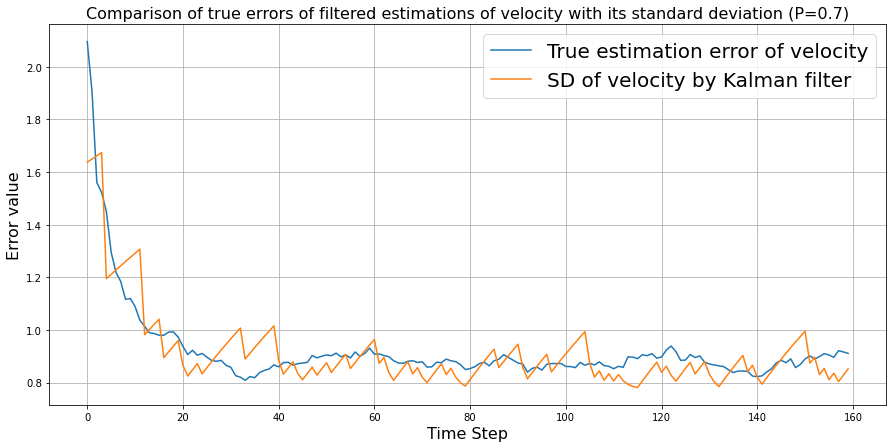

In [86]:
showPlease([true_errV_c[20:180], kalman_c.givePErrorV()[20:180]], 
           ['True estimation error of velocity',  
           'SD of velocity by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true errors of filtered estimations of velocity with its standard deviation (P=0.7)');

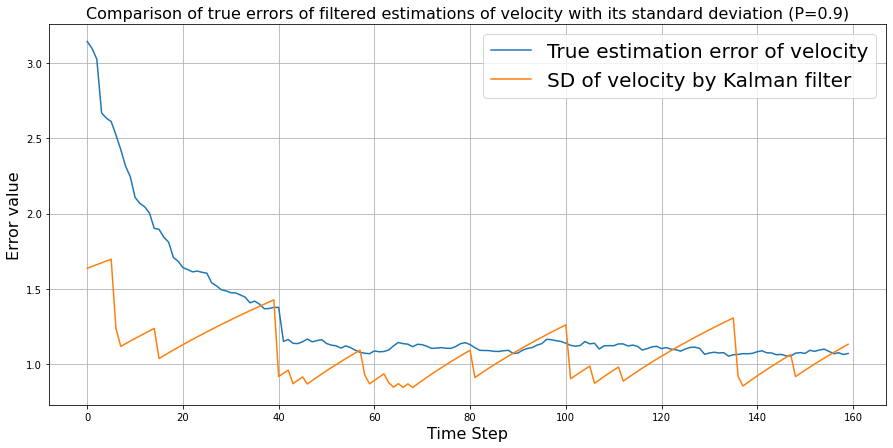

In [87]:
showPlease([true_errV_d[20:180], kalman_d.givePErrorV()[20:180]], 
           ['True estimation error of velocity',  
           'SD of velocity by Kalman filter'], 
           'Time Step', 'Error value', 
           'Comparison of true errors of filtered estimations of velocity with its standard deviation (P=0.9)');

**The same trend is observed for velocity values - the larger the gap probability, the larger the errors. True estimation errors correspond to standard deviation values except for the last case - when the gap probability is too high (0.9, in this case), true estimation errors turn out to be larger than the calculated ones by the filter, thus, there is a limit for the gap probability value when accuracy of filtered estimates start decreasing.**

**Conclusion: This time we faced the situation of incomplete measurement data set which is frequently met among many practical control and forecasting problems. Firstly, as always, we generated true trajectory and measurement values - the function to define the latter was supplemented by the condition of gap probability. Then, we started developing optimised Kalman filter algorithm. We could not skip filtration procedure and we needed to supplement somehow the set of measurements so that it does not have any gaps, otherwise the filter would diverge and we would lose the object under study. In order to optimise the filter, on the filtration step, we indicated that in case of a gap the filtered estimate should be equal to extrapolated estimate and filtration error covariance matrix should be equal to extrapolation error covariance matrix - we did not have any other better information at this point. Thus, we obtained a full array of measurement values which were successfuly filtered. Comparison of true estimation errors for filtered and extrapolated estimates with standard deviation calculated by Kalman filter revealed that the filter indeed operates in case of incomplete measurement set with quite good accuracy (achieving its limit), and forecased estimations on 7 steps ahead have ~1.5 times larger errors than the ones with just 1 step ahead forecast, so the filter provides us with accurate output data even in case of extrapolation. After comparison of SD and measurement values, it was also noted that the crests of SD corresponded to the gaps of measurements. The increase of gap probability, as it was expected, led to higher figures for errors, but it should be noted that the loss of the half of measurements resulted in only 10 units of true estimation errors. However, the last case of 90% loss showed us the limits of Kalman filter applicability as this kind of loss turned out to be more significant so that true estimation errors of coordinate were > 50 units at the beginning of observational interval stabilizing at > 20 units after ~30 time step. Therefore, the way we see it: although the filter successfuly deals with gap probabilities up to 70%, the further increase of this value leads to a more dramatical rise of errors.**